In [1]:
from movielens import *
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import sys
import time
import pickle

In [2]:
user = []
item = []
rating = []
rating_test = []

# Load the movie lens dataset into arrays
d = Dataset()
d.load_users("data/u.user", user)
d.load_items("data/u.item", item)
d.load_ratings("data/u.base", rating)
d.load_ratings("data/u.test", rating_test)

n_users = len(user)
n_items = len(item)


In [3]:
utility = np.zeros((n_users, n_items))
for r in rating:
    utility[r.user_id-1][r.item_id-1] = r.rating

# Finds the average rating for each user and stores it in the user's object
for i in range(n_users):
    rated = np.nonzero(utility[i])
    n = len(rated[0])
    if n != 0:
        user[i].avg_r = np.mean(utility[i][rated])
    else:
        user[i].avg_r = 0.

print utility

[[ 5.  3.  4. ...,  0.  0.  0.]
 [ 4.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  5.  0. ...,  0.  0.  0.]]


In [4]:
test = np.zeros((n_users, n_items))
for r in rating_test:
    test[r.user_id - 1][r.item_id - 1] = r.rating

In [5]:
movie_genre = []
for movie in item:
    movie_genre.append([movie.unknown, movie.action, movie.adventure, movie.animation, movie.childrens, movie.comedy,
                        movie.crime, movie.documentary, movie.drama, movie.fantasy, movie.film_noir, movie.horror,
                        movie.musical, movie.mystery, movie.romance, movie.sci_fi, movie.thriller, movie.war, movie.western])

movie_genre = np.array(movie_genre)
cluster = KMeans(n_clusters=19)
cluster.fit_predict(movie_genre)

array([7, 4, 9, ..., 6, 2, 1], dtype=int32)

In [6]:
utility_clustered = []
for i in range(0, n_users):
    average = np.zeros(19)
    tmp = []
    for m in range(0, 19):
        tmp.append([])
    for j in range(0, n_items):
        if utility[i][j] != 0:
            tmp[cluster.labels_[j] - 1].append(utility[i][j])
    for m in range(0, 19):
        if len(tmp[m]) != 0:
            average[m] = np.mean(tmp[m])
        else:
            average[m] = 0
    utility_clustered.append(average)

utility_clustered = np.array(utility_clustered)

In [7]:
for i in range(0, n_users):
    x = utility_clustered[i]
    user[i].avg_r = sum(a for a in x if a > 0) / sum(a > 0 for a in x)

In [ ]:
def pcs(x, y):
    num = 0
    den1 = 0
    den2 = 0
    A = utility_clustered[x - 1]
    B = utility_clustered[y - 1]
    num = sum((a - user[x - 1].avg_r) * (b - user[y - 1].avg_r) for a, b in zip(A, B) if a > 0 and b > 0)
    den1 = sum((a - user[x - 1].avg_r) ** 2 for a in A if a > 0)
    den2 = sum((b - user[y - 1].avg_r) ** 2 for b in B if b > 0)
    den = (den1 ** 0.5) * (den2 ** 0.5)
    if den == 0:
        return 0
    else:
        return num / den

In [ ]:
pcs_matrix = np.zeros((n_users, n_users))
for i in range(0, n_users):
    for j in range(0, n_users):
        if i!=j:
            pcs_matrix[i][j] = pcs(i + 1, j + 1)
            sys.stdout.write("\rGenerating Similarity Matrix [%d:%d] = %f" % (i+1, j+1, pcs_matrix[i][j]))
            sys.stdout.flush()
            time.sleep(0.00005)
print "\rGenerating Similarity Matrix [%d:%d] = %f" % (i+1, j+1, pcs_matrix[i][j])

print pcs_matrix

Generating Similarity Matrix [943:943] = 0.0000001
[[ 0.         -0.06608723  0.18146379 ...,  0.18472761 -0.20460001
  -0.00960451]
 [-0.06608723  0.          0.23805647 ..., -0.04978212  0.27586287
  -0.26217861]
 [ 0.18146379  0.23805647  0.         ..., -0.28636144  0.15892122
   0.12981704]
 ..., 
 [ 0.18472761 -0.04978212 -0.28636144 ...,  0.         -0.12236965
  -0.09736123]
 [-0.20460001  0.27586287  0.15892122 ..., -0.12236965  0.          0.25194945]
 [-0.00960451 -0.26217861  0.12981704 ..., -0.09736123  0.25194945  0.        ]]


In [ ]:
# Guesses the ratings that user with id, user_id, might give to item with id, i_id.
# We will consider the top_n similar users to do this.
def norm():
    normalize = np.zeros((n_users, 19))
    for i in range(0, n_users):
        for j in range(0, 19):
            if utility_clustered[i][j] != 0:
                normalize[i][j] = utility_clustered[i][j] - user[i].avg_r
            else:
                normalize[i][j] = float('Inf')
    return normalize

In [ ]:
def guess(user_id, i_id, top_n):
    similarity = []
    for i in range(0, n_users):
        if i+1 != user_id:
            similarity.append(pcs_matrix[user_id-1][i])
    temp = norm()
    temp = np.delete(temp, user_id-1, 0)
    top = [x for (y,x) in sorted(zip(similarity,temp), key=lambda pair: pair[0], reverse=True)]
    s = 0
    c = 0
    for i in range(0, top_n):
        if top[i][i_id-1] != float('Inf'):
            s += top[i][i_id-1]
            c += 1
    g = user[user_id-1].avg_r if c == 0 else s/float(c) + user[user_id-1].avg_r
    if g < 1.0:
        return 1.0
    elif g > 5.0:
        return 5.0
    else:
        return g

In [ ]:
utility_copy = np.copy(utility_clustered)
for i in range(0, n_users):
    for j in range(0, 19):
        if utility_copy[i][j] == 0:
            sys.stdout.write("\rGuessing [User:Rating] = [%d:%d]" % (i, j))
            sys.stdout.flush()
            time.sleep(0.00005)
            utility_copy[i][j] = guess(i+1, j+1, 150)
print "\rGuessing [User:Rating] = [%d:%d]" % (i, j)

In [ ]:
pickle.dump( utility_copy, open("utility_matrix.pkl", "wb"))

## Result

In [18]:
# Predict ratings for u.test and find the mean squared error
y_true = []
y_pred = []
f = open('test.txt', 'w')
for i in range(0, n_users):
    for j in range(0, n_items):
        if test[i][j] > 0:
            f.write("%d, %d, %.4f\n" % (i+1, j+1, utility_copy[i][cluster.labels_[j]-1]))
            y_true.append(test[i][j])
            y_pred.append(utility_copy[i][cluster.labels_[j]-1])
f.close()

print "Mean Squared Error: %f" % mean_squared_error(y_true, y_pred)


Mean Squared Error: 1.255988


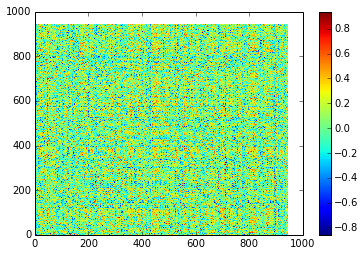

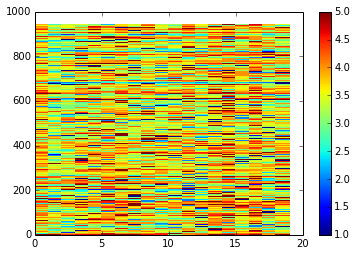

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#x, y = np.meshgrid(x, y)
plt.pcolormesh(pcs_matrix)
plt.colorbar() #need a colorbar to show the intensity scale
plt.show() #boom
plt.pcolormesh(utility_copy)
plt.colorbar() #need a colorbar to show the intensity scale
plt.show() #boom